In [1]:
import os
import torch
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from transformers import LongformerTokenizer, LongformerModel, AutoTokenizer, AutoModel
from pycaret.classification import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
# Get the root directory of the project (assuming the notebook is inside "notebook/")
notebook_dir = os.getcwd()  # Gets the current working directory
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Moves one level up
project_root

'C:\\Users\\jeiso\\Documents\\Maestria\\Semestre #1\\NLP\\IberLEF2025\\MentalRiskES'

In [3]:
path_dataset = os.path.join(project_root, "data", "dataset_task2.xlsx")
dataset = pd.read_excel(path_dataset)
dataset['message'] = dataset['message'].fillna("").astype(str)
dataset.head()

,message,label_text,level,label
0,el canal del amigo se llama loco por el tradin...,trading,0,1
1,ganancia e ganancia chico [SEP] si lo conseguí...,trading,0,1
2,fijate cuanto e el margen en negativo y le agr...,trading,1,1
3,alguna entradita .. ? [SEP] spot está funciona...,trading,0,1
4,voy cargando la escopeta pa longuear alguna mo...,trading,1,1


# TASK 1: BINARY CLASSIFICATION

In [4]:
x_task1 = dataset['message']
y_task1 = dataset['level']

In [5]:
# load model and tokenizer

# Longformer
#model_name = "PlanTL-GOB-ES/longformer-base-4096-bne-es"
#tokenizer = LongformerTokenizer.from_pretrained(model_name)
#model = LongformerModel.from_pretrained(model_name).to(device)

# BETO
model_name = "dccuchile/bert-base-spanish-wwm-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def get_longformer_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    )
    # Mover los tensores de entrada a GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Convertir los resultados a CPU para trabajar con numpy
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Aplicamos la función a todos los mensajes
x_task1_embeddings = np.array([get_longformer_embedding(text) for text in x_task1])

In [7]:
x_task1_embeddings

array([[-0.09902813, -0.15904334, -0.30138153, ..., -0.33458328,
         0.2695182 ,  0.22862685],
       [-0.14719549, -0.1112902 , -0.16692387, ..., -0.23385125,
         0.05203149,  0.10748015],
       [-0.1551729 , -0.03288925, -0.22002526, ..., -0.17964064,
         0.0976115 ,  0.19014117],
       ...,
       [ 0.13345632, -0.08678578, -0.04402681, ..., -0.30821866,
         0.23617628, -0.03853274],
       [ 0.2602157 ,  0.07340417,  0.06921416, ..., -0.2064684 ,
         0.52956724,  0.15044431],
       [-0.22404031,  0.09983473, -0.14697447, ..., -0.11260161,
         0.27668977,  0.23247115]], dtype=float32)

In [8]:
print('**Sample train:', sorted(Counter(y_task1).items()))

**Sample train: [(0, 178), (1, 231)]


In [9]:
# We create an instance of RandomOverSampler to balance the classes.
# - random_state=10000: A seed is set for reproducibility.

ros_task1 = RandomOverSampler(random_state=10000)

# We apply oversampling to generate new instances of the minority classes to equal the amount of the majority class.
x_task1, y_task1 = ros_task1.fit_resample(x_task1_embeddings, y_task1)

# We show the distribution of classes after oversampling.
print('**OverSample train:', sorted(Counter(y_task1).items()))

**OverSample train: [(0, 231), (1, 231)]


In [10]:
x_task1

array([[-0.09902813, -0.15904334, -0.30138153, ..., -0.33458328,
         0.2695182 ,  0.22862685],
       [-0.14719549, -0.1112902 , -0.16692387, ..., -0.23385125,
         0.05203149,  0.10748015],
       [-0.1551729 , -0.03288925, -0.22002526, ..., -0.17964064,
         0.0976115 ,  0.19014117],
       ...,
       [-0.14719549, -0.1112902 , -0.16692387, ..., -0.23385125,
         0.05203149,  0.10748015],
       [-0.12730634, -0.09077215, -0.11596057, ..., -0.24794453,
         0.24860023,  0.27696827],
       [ 0.02016972, -0.36212692, -0.10957462, ..., -0.10649268,
         0.2479343 ,  0.10699616]], dtype=float32)

In [11]:
setup_task1 = setup(
    data=x_task1, # Input data set (feature matrix)
    target=y_task1, # Target variable (classification labels)
    session_id=123, # Random seed to ensure reproducibility
    train_size=0.80, # Percentage of data used for training (80%)
    log_experiment=True, # Enable experiment logging (mlflow)
    experiment_name='Mentalrisk_task1' # Name of experiment for tracking (mlflow)
)

,Description,Value
0,Session id,123
1,Target,level
2,Target type,Binary
3,Original data shape,"(462, 769)"
4,Transformed data shape,"(462, 769)"
5,Transformed train set shape,"(369, 769)"
6,Transformed test set shape,"(93, 769)"
7,Numeric features,768
8,Preprocess,True
9,Imputation type,simple


In [12]:
# We compared multiple classification models using cross-validation with 10 folds.
model_task1 = compare_models(fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:22:47
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7505,0.8301,0.6909,0.7839,0.7315,0.5005,0.5072,0.1270
lr,Logistic Regression,0.7426,0.8272,0.7120,0.7601,0.7303,0.4846,0.4906,0.2830
ridge,Ridge Classifier,0.7424,0.8211,0.7026,0.7657,0.7288,0.4852,0.4906,0.0270
et,Extra Trees Classifier,0.7397,0.8303,0.6798,0.7742,0.7221,0.4785,0.4837,0.0410
rf,Random Forest Classifier,0.7289,0.8333,0.6532,0.7721,0.7053,0.4576,0.4650,0.0620
ada,Ada Boost Classifier,0.7208,0.7743,0.6754,0.7637,0.7088,0.4419,0.4541,0.1500
gbc,Gradient Boosting Classifier,0.7179,0.8099,0.6863,0.7392,0.7092,0.4358,0.4396,0.6700
svm,SVM - Linear Kernel,0.7047,0.8249,0.6319,0.7974,0.6549,0.4090,0.4561,0.0250
lda,Linear Discriminant Analysis,0.6965,0.6962,0.6588,0.7254,0.6802,0.3928,0.4029,0.0240
knn,K Neighbors Classifier,0.6935,0.7523,0.6588,0.7088,0.6785,0.3869,0.3907,0.2260


2025/04/06 07:23:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 07:23:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 07:23:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 07:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 07:23:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/04/06 07:23:10 

In [32]:
# We create a classification model.
best_model = create_model('lightgbm')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,07:53:36
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7297,0.8363,0.6316,0.8000,0.7059,0.4622,0.4733
1,0.7297,0.8246,0.6316,0.8000,0.7059,0.4622,0.4733
2,0.8108,0.8596,0.7368,0.8750,0.8000,0.6230,0.6313
3,0.8108,0.8947,0.8947,0.7727,0.8293,0.6197,0.6281
4,0.7838,0.9094,0.7368,0.8235,0.7778,0.5685,0.5718
5,0.6216,0.7076,0.5000,0.6429,0.5625,0.2382,0.2441
6,0.7568,0.8158,0.6667,0.8000,0.7273,0.5110,0.5179
7,0.8378,0.8596,0.8333,0.8333,0.8333,0.6754,0.6754
8,0.7297,0.8099,0.6111,0.7857,0.6875,0.4559,0.4671


2025/04/06 07:53:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [33]:
print(best_model)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)


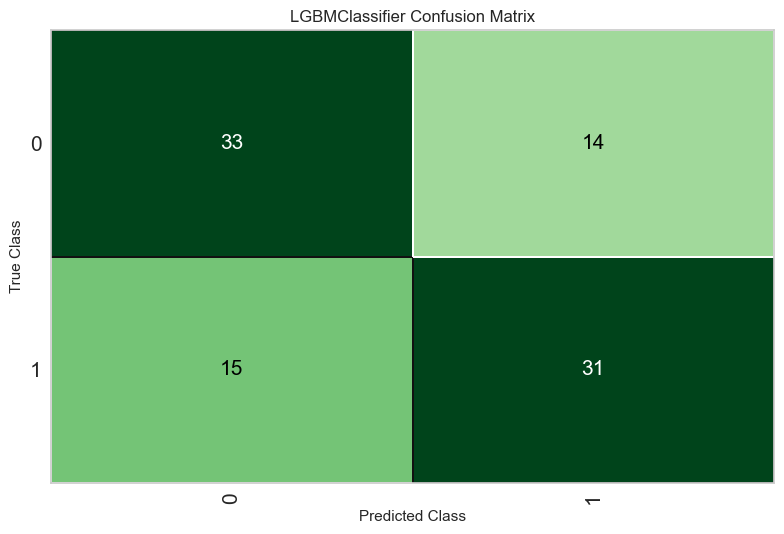

In [34]:
plot_model(best_model, plot='confusion_matrix')

In [35]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [23]:
final_model = finalize_model(best_model)

2025/04/06 07:25:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [36]:
save_model(final_model, 'lightgbm_task1_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['feature_1', 'feature_2',
                                              'feature_3', 'feature_4',
                                              'feature_5', 'feature_6',
                                              'feature_7', 'feature_8',
                                              'feature_9', 'feature_10',
                                              'feature_11', 'feature_12',
                                              'feature_13', 'feature_14',
                                              'feature_15', 'feature_16',
                                              'feature_17', 'feature_18',
                                              'feature_19', 'feat...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                 colsample_bytree=1.0, importance_type